In [1]:
import urllib, json
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors

In [2]:
areas_url = 'https://opendata.comune.ra.it/dataset/5ec2b0b3-24f7-4b75-987d-f53658d80064/resource/a8402fb2-3fd5-4a53-a691-263bb8e82640/download/sitra01aa01areeterritoriali.geojson'
areas_response = urllib.request.urlopen(areas_url)
areas_data = json.loads(areas_response.read())
#print(areas_data)
areas = gpd.GeoDataFrame.from_features(areas_data)
areas = areas[['geometry', 'NOME_AT']]
areas = areas.rename( columns = { 'NOME_AT' : 'frazione' } )
areas = areas.set_crs('epsg:4326')
areas = areas.to_crs( epsg = 32633 ) #utm
# print(areas.head(3))

In [3]:
points_url = 'https://opendata.comune.ra.it/dataset/01a9ed32-3b1c-4d0c-b20f-ef0fb5d22c4e/resource/6d4f0753-27af-4d70-aed9-f253c8da4c4f/download/aree_verdi.geojson'
points_response = urllib.request.urlopen(points_url)
points_data = json.loads(points_response.read())
# print(points_data)
points = gpd.GeoDataFrame.from_features(points_data)
points = points[['NOME', 'SOTTOTIPO', 'geometry']]
points = points[ points['SOTTOTIPO'] == 'AREA SGAMBAMENTO CANI' ]
points = points.drop( columns = ['SOTTOTIPO'] )
points = points.rename( columns = { 'NOME' : 'nome' } )
points = points.set_crs('epsg:3004')
points = points.to_crs( epsg = 32633 ) #utm
# print(pints.head(3))

In [4]:
small_buff = points[:]
small_buff['geometry'] = small_buff.geometry.buffer(500)
small_buff['dissovefield'] = 1
small_buff = small_buff.dissolve( by = 'dissovefield' )
small_buff = small_buff.overlay(areas, how='intersection')

In [5]:
big_buff = points[:]
big_buff['geometry'] = big_buff.geometry.buffer(1250)
big_buff = big_buff.overlay(areas, how='intersection')
# print(big_buff.head(3))

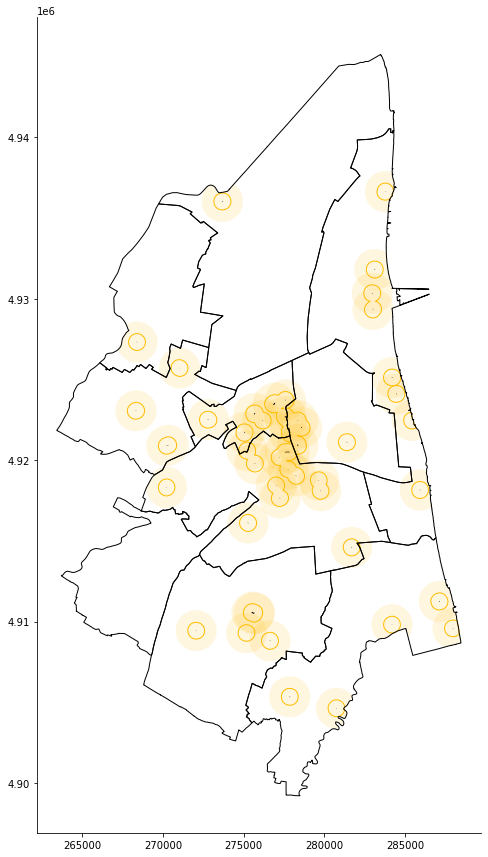

In [6]:
fig, ax = plt.subplots( figsize = (20, 15) )
big_buff.plot(ax = ax, color = '#FFBD0020')
small_buff.plot(ax = ax, color = 'none', linewidth = 1, edgecolor = '#FFBD00')
points.plot(ax = ax, color = 'black')
areas.plot(ax = ax, color = 'none', edgecolor = 'black')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.savefig( 'dogs.jpg', dpi = 150 )

In [7]:
coverage = big_buff.dissolve( by = 'frazione', aggfunc = 'sum' )
coverage = coverage.rename( columns = { 'geometry' : 'buffer' } )
coverage = coverage.merge( areas, on = 'frazione' )
coverage['buffer_kmq'] = coverage['buffer'].area / 10**6 # km
coverage['geometry_kmq'] = coverage['geometry'].area / 10**6
coverage['covered_percent'] = 100 * coverage['buffer_kmq'] / coverage['geometry_kmq']

In [8]:
def inter_from_256(x):
    return np.interp(x=x,xp=[0,255],fp=[0,1])

cdict = {
    'red' : ((0.0, 1, 1),
            (1.0, inter_from_256(255), inter_from_256(255))),
    'green' : ((0.0, 1, 1),
            (1.0, inter_from_256(189), inter_from_256(189))),
    'blue' : ((0.0, 1, 1),
            (1.0, inter_from_256(0), inter_from_256(0)))
}
y_grd = matplotlib.colors.LinearSegmentedColormap('y_grd', segmentdata=cdict)

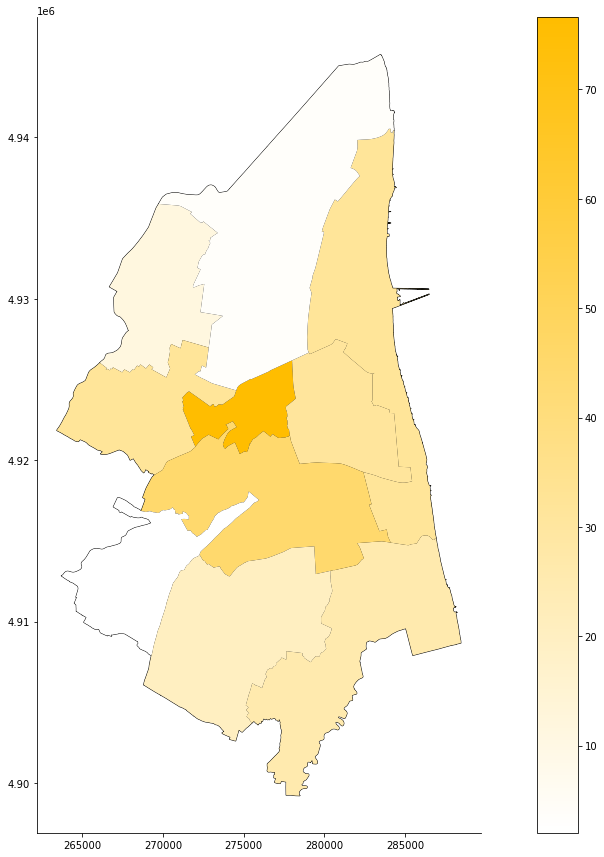

In [9]:
map = coverage[['frazione', 'geometry', 'covered_percent']]
    
fig, ax = plt.subplots( figsize = (20, 15) )
base = areas.plot( ax = ax, 
                  color = 'none', 
                  edgecolor = 'black' # , figsize = (20, 15)
                 ) 
map.plot( ax = ax, 
         column = 'covered_percent', 
         cmap = y_grd, 
         legend = True 
        )
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)